In [1]:
#hide
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [2]:
#hide
from fastbook import *

# Image Classification

## From Dogs and Cats to Pet Breeds

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('images'),Path('annotations')]

In [6]:
(path/"images").ls()

(#7393) [Path('images/german_shorthaired_53.jpg'),Path('images/pug_196.jpg'),Path('images/staffordshire_bull_terrier_179.jpg'),Path('images/Egyptian_Mau_215.jpg'),Path('images/Russian_Blue_149.jpg'),Path('images/beagle_108.jpg'),Path('images/german_shorthaired_173.jpg'),Path('images/Abyssinian_14.jpg'),Path('images/chihuahua_126.jpg'),Path('images/British_Shorthair_86.jpg')...]

In [7]:
fname = (path/"images").ls()[0]

In [8]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['german_shorthaired']

In [9]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

/home/ubuntu/miniconda3/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


## Presizing

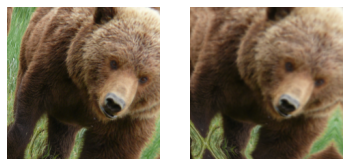

In [10]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

### Checking and Debugging a DataBlock

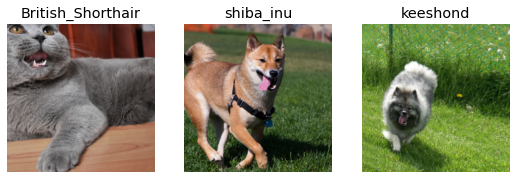

In [11]:
dls.show_batch(nrows=1, ncols=3)

In [13]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
# pets1.summary(path/"images")

In [14]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.466413,0.345278,0.108254,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.511397,0.333504,0.100135,00:56
1,0.324862,0.239187,0.080514,00:57


## Cross-Entropy Loss

### Viewing Activations and Labels

In [15]:
x,y = dls.one_batch()

In [16]:
y

TensorCategory([ 1, 16, 24,  2, 29,  9, 18, 32, 34,  1, 15, 18, 24, 20, 20, 28,  3, 30, 27, 13,  8, 23, 23, 23, 25, 10, 22,  9, 17,  4, 32,  8, 13, 14, 15, 25, 22, 11,  0, 18, 29, 24,  0, 20, 24, 29, 31, 14,
        29, 14,  7, 15,  5,  6,  8,  3,  2, 36, 33,  9, 29, 11,  8, 35], device='cuda:0')

In [17]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

TensorBase([1.1856e-05, 9.9928e-01, 2.1337e-07, 1.4257e-05, 2.3738e-05, 1.7050e-04, 5.1729e-05, 2.4738e-06, 4.0877e-07, 1.1918e-05, 8.8435e-07, 1.3824e-04, 2.8801e-06, 1.6241e-06, 1.7368e-06, 2.0571e-06,
        3.1873e-05, 1.0543e-06, 4.5568e-06, 6.1898e-05, 6.9092e-06, 1.5630e-06, 5.2008e-07, 1.5268e-07, 8.1492e-07, 2.8946e-06, 1.4189e-04, 5.6234e-06, 4.0500e-07, 2.0204e-06, 8.4873e-07, 1.6158e-07,
        6.4228e-06, 5.2102e-07, 3.7455e-06, 7.3229e-07, 6.7191e-06])

In [18]:
len(preds[0]),preds[0].sum()

(37, TensorBase(1.0000))

### Softmax

/home/ubuntu/miniconda3/lib/python3.9/site-packages/fastbook/__init__.py:74: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


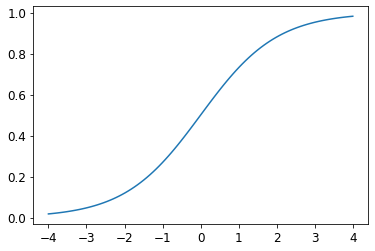

In [19]:
plot_function(torch.sigmoid, min=-4,max=4)

In [20]:
#hide
torch.random.manual_seed(42);

In [21]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [22]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [23]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [24]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log Likelihood

In [25]:
targ = tensor([0,1,0,1,1,0])

In [26]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [27]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [28]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.996640,0.003360,1,3,0.003360
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [29]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [30]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the Log

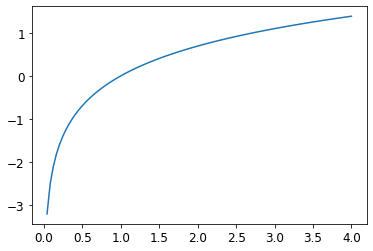

In [31]:
plot_function(torch.log, min=0,max=4)

In [32]:
loss_func = nn.CrossEntropyLoss()

In [33]:
loss_func(acts, targ)

tensor(1.8045)

In [34]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [35]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

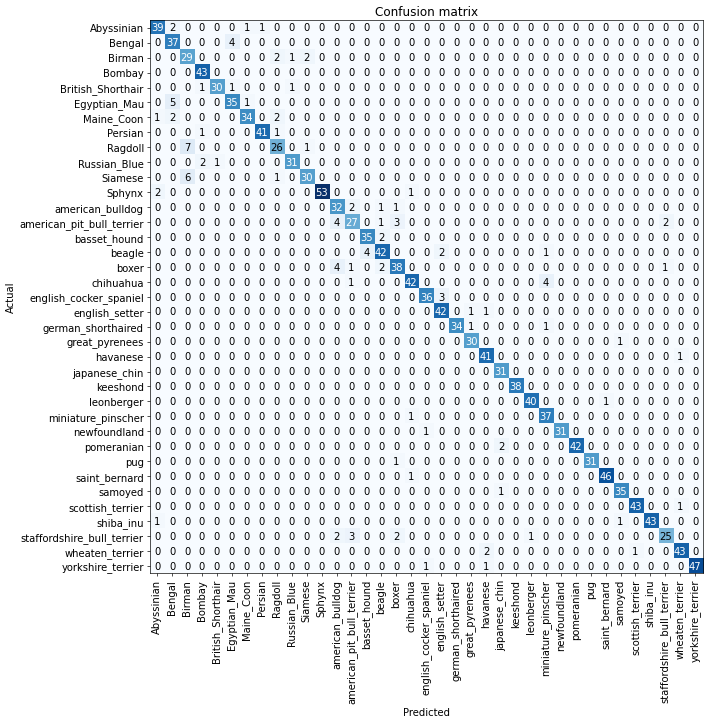

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [37]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 7),
 ('Siamese', 'Birman', 6),
 ('Egyptian_Mau', 'Bengal', 5)]

## Improving Our Model

### The Learning Rate Finder

In [38]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.561399,5.401166,0.496617,00:45


epoch,train_loss,valid_loss,error_rate,time
0,3.736299,2.321333,0.659675,00:57


SuggestedLRs(valley=0.0005754399462603033)

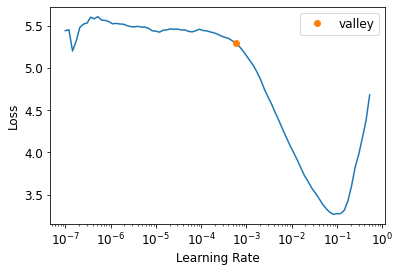

In [40]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.lr_find()

In [43]:
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [44]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.352553,0.362237,0.109608,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.550512,0.376293,0.106901,00:56
1,0.324029,0.244841,0.077131,00:57


### Unfreezing and Transfer Learning

In [45]:
learn.fine_tune??

In [46]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.115054,0.304985,0.095399,00:45
1,0.519177,0.249707,0.075778,00:44
2,0.317153,0.237411,0.068336,00:45


In [47]:
learn.unfreeze()

SuggestedLRs(valley=2.0892961401841603e-05)

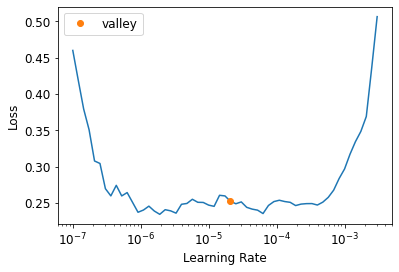

In [48]:
learn.lr_find()

In [49]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.258665,0.226668,0.064953,00:57
1,0.250423,0.223302,0.066982,00:58
2,0.228955,0.216151,0.064953,00:58
3,0.206815,0.211473,0.062923,01:19
4,0.189291,0.211144,0.062923,01:36
5,0.181676,0.213173,0.063599,01:37


### Discriminative Learning Rates

In [50]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.138911,0.392137,0.115697,00:59
1,0.534686,0.292620,0.087957,01:01
2,0.311747,0.252642,0.076455,01:22


epoch,train_loss,valid_loss,error_rate,time
0,0.251085,0.247814,0.078484,01:50
1,0.262688,0.233685,0.067659,01:52
2,0.251710,0.230773,0.068336,01:52
3,0.209636,0.219835,0.060893,01:50
4,0.205809,0.226113,0.070365,01:53
5,0.173798,0.218260,0.061570,01:49
6,0.159615,0.215565,0.068336,01:53
7,0.138474,0.211567,0.064276,01:01
8,0.133590,0.209138,0.064953,00:58
9,0.122277,0.207825,0.062246,01:05


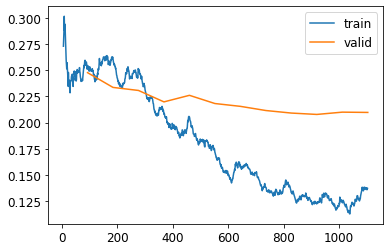

In [51]:
learn.recorder.plot_loss()

### Selecting the Number of Epochs

### Deeper Architectures

In [54]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet18, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,5.219101,4.166701,0.959405,00:33
1,5.076233,3.904340,0.941137,00:44
2,4.687771,3.519278,0.897158,00:56


epoch,train_loss,valid_loss,error_rate,time
0,4.399516,3.456651,0.885656,00:57
1,4.204472,3.282815,0.862652,00:57
2,4.033324,3.133910,0.822733,00:59
3,3.874115,3.037734,0.807848,00:57
4,3.849510,2.979922,0.786874,00:56
5,3.772631,2.973923,0.785521,00:56


## Conclusion

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book's website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods that it adds.
1. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a `DataLoaders`?
1. What method does fastai provide to help you debug a `DataBlock`?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross-entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the `exp` and `softmax` columns of <<bear_softmax>> yourself (i.e., in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the `fine_tune` method do?
1. In Jupyter Notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python `slice` object interpreted when passed as a learning rate to fastai?
1. Why is early stopping a poor choice when using 1cycle training?
1. What is the difference between `resnet50` and `resnet101`?
1. What does `to_fp16` do?

### Further Research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Look on the forums and the book's website to see what other students have achieved with this dataset, and how they did it.